In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import os
import random
import numpy as np

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [12]:
seed =42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3 

In [13]:
TRAIN_PATH='/content/drive/My Drive/dents/train'
TEST_PATH='/content/drive/My Drive/dents/test'

train_ids= next(os.walk(TRAIN_PATH))[1]
test_ids= next(os.walk(TEST_PATH))[1]

print(train_ids)

['18', '1', '10', '16', '17', '11', '13', '12', '15', '14', '22', '24', '20', '21', '2', '25', '23', '19', '27', '26', '32', '31', '33', '36', '3', '34', '29', '28', '30', '35', '42', '44', '43', '37', '40', '38', '39', '45', '4', '41', '52', '5', '47', '50', '49', '6', '51', '7', '48', '46', '8', '9']


In [14]:
X_train = np.zeros ((len(train_ids),IMG_HEIGHT,IMG_WIDTH , IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros(( len(train_ids),IMG_HEIGHT,IMG_WIDTH , 1 ),dtype=np.bool)

print ('resizing training images and masks')
for n, id_ in tqdm (enumerate(train_ids), total=len(train_ids)):
     path = TRAIN_PATH + '/' +id_
     img = imread(path + '/images/'+ id_ + '.jpg')[:,:,:IMG_CHANNELS]
     img= resize (img, (IMG_HEIGHT,IMG_WIDTH), mode='constant', preserve_range=True)
     X_train[n] = img
     mask = np.zeros((IMG_HEIGHT,IMG_WIDTH , 1 ),dtype=np.bool)
     for mask_file in next(os.walk(path +'/masks/'))[2]:
         mask_ = imread(path + '/masks/'+ mask_file)
         mask_ = np.expand_dims(resize (mask_, (IMG_HEIGHT,IMG_WIDTH), mode='constant', preserve_range=True),axis=-1)
         mask = np.maximum(mask, mask_)
     Y_train[n] = mask 


  0%|          | 0/52 [00:00<?, ?it/s]

resizing training images and masks


100%|██████████| 52/52 [01:31<00:00,  1.77s/it]


In [15]:
#test images

X_test = np.zeros ((len(test_ids),IMG_HEIGHT,IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test= []

print ('resizing test images')
for n, id_ in tqdm (enumerate(test_ids), total=len(test_ids)):
     path = TEST_PATH + '/' +id_
     img = imread(path + '/images/'+ id_ + '.jpg')[:,:,:IMG_CHANNELS]
     sizes_test.append([img.shape[0], img.shape[1]])
     img= resize (img, (IMG_WIDTH, IMG_HEIGHT), mode='constant', preserve_range=True)
     X_test[n] = img

print('done')


  0%|          | 0/6 [00:00<?, ?it/s]

resizing test images


100%|██████████| 6/6 [00:16<00:00,  2.75s/it]

done


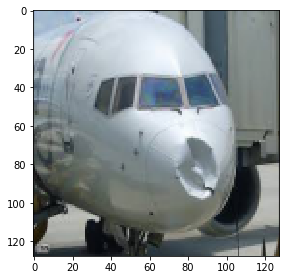

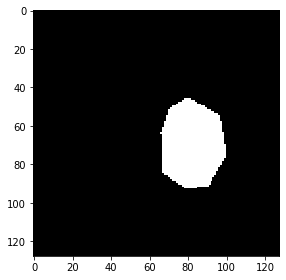

In [16]:
image_x= random.randint(0, len(train_ids))
imshow(np.squeeze(X_train[image_x]))
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

build the model

In [17]:
#DropBlock1D
import keras
import keras.backend as K


class DropBlock1D(keras.layers.Layer):
    """See: https://arxiv.org/pdf/1810.12890.pdf"""

    def __init__(self,
                 block_size,
                 keep_prob,
                 sync_channels=False,
                 data_format=None,
                 **kwargs):
        """Initialize the layer.
        :param block_size: Size for each mask block.
        :param keep_prob: Probability of keeping the original feature.
        :param sync_channels: Whether to use the same dropout for all channels.
        :param data_format: 'channels_first' or 'channels_last' (default).
        :param kwargs: Arguments for parent class.
        """
        super(DropBlock1D, self).__init__(**kwargs)
        self.block_size = block_size
        self.keep_prob = keep_prob
        self.sync_channels = sync_channels
        self.data_format = K.normalize_data_format(data_format)
        self.input_spec = keras.engine.base_layer.InputSpec(ndim=3)
        self.supports_masking = True

    def get_config(self):
        config = {'block_size': self.block_size,
                  'keep_prob': self.keep_prob,
                  'sync_channels': self.sync_channels,
                  'data_format': self.data_format}
        base_config = super(DropBlock1D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_mask(self, inputs, mask=None):
        return mask

    def compute_output_shape(self, input_shape):
        return input_shape

    def _get_gamma(self, feature_dim):
        """Get the number of activation units to drop"""
        feature_dim = K.cast(feature_dim, K.floatx())
        block_size = K.constant(self.block_size, dtype=K.floatx())
        return ((1.0 - self.keep_prob) / block_size) * (feature_dim / (feature_dim - block_size + 1.0))

    def _compute_valid_seed_region(self, seq_length):
        positions = K.arange(seq_length)
        half_block_size = self.block_size // 2
        valid_seed_region = K.switch(
            K.all(
                K.stack(
                    [
                        positions >= half_block_size,
                        positions < seq_length - half_block_size,
                    ],
                    axis=-1,
                ),
                axis=-1,
            ),
            K.ones((seq_length,)),
            K.zeros((seq_length,)),
        )
        return K.expand_dims(K.expand_dims(valid_seed_region, axis=0), axis=-1)

    def _compute_drop_mask(self, shape):
        seq_length = shape[1]
        mask = K.random_binomial(shape, p=self._get_gamma(seq_length))
        mask *= self._compute_valid_seed_region(seq_length)
        mask = keras.layers.MaxPool1D(
            pool_size=self.block_size,
            padding='same',
            strides=1,
            data_format='channels_last',
        )(mask)
        return 1.0 - mask

    def call(self, inputs, training=None):

        def dropped_inputs():
            outputs = inputs
            if self.data_format == 'channels_first':
                outputs = K.permute_dimensions(outputs, [0, 2, 1])
            shape = K.shape(outputs)
            if self.sync_channels:
                mask = self._compute_drop_mask([shape[0], shape[1], 1])
            else:
                mask = self._compute_drop_mask(shape)
            outputs = outputs * mask *\
                (K.cast(K.prod(shape), dtype=K.floatx()) / K.sum(mask))
            if self.data_format == 'channels_first':
                outputs = K.permute_dimensions(outputs, [0, 2, 1])
            return outputs

        return K.in_train_phase(dropped_inputs, inputs, training=training)


class DropBlock2D(keras.layers.Layer):
    """See: https://arxiv.org/pdf/1810.12890.pdf"""

    def __init__(self,
                 block_size,
                 keep_prob,
                 sync_channels=False,
                 data_format=None,
                 **kwargs):
        """Initialize the layer.
        :param block_size: Size for each mask block.
        :param keep_prob: Probability of keeping the original feature.
        :param sync_channels: Whether to use the same dropout for all channels.
        :param data_format: 'channels_first' or 'channels_last' (default).
        :param kwargs: Arguments for parent class.
        """
        super(DropBlock2D, self).__init__(**kwargs)
        self.block_size = block_size
        self.keep_prob = keep_prob
        self.sync_channels = sync_channels
        self.data_format = K.normalize_data_format(data_format)
        self.input_spec = keras.engine.base_layer.InputSpec(ndim=4)
        self.supports_masking = True

    def get_config(self):
        config = {'block_size': self.block_size,
                  'keep_prob': self.keep_prob,
                  'sync_channels': self.sync_channels,
                  'data_format': self.data_format}
        base_config = super(DropBlock2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_mask(self, inputs, mask=None):
        return mask

    def compute_output_shape(self, input_shape):
        return input_shape

    def _get_gamma(self, height, width):
        """Get the number of activation units to drop"""
        height, width = K.cast(height, K.floatx()), K.cast(width, K.floatx())
        block_size = K.constant(self.block_size, dtype=K.floatx())
        return ((1.0 - self.keep_prob) / (block_size ** 2)) *\
               (height * width / ((height - block_size + 1.0) * (width - block_size + 1.0)))

    def _compute_valid_seed_region(self, height, width):
        positions = K.concatenate([
            K.expand_dims(K.tile(K.expand_dims(K.arange(height), axis=1), [1, width]), axis=-1),
            K.expand_dims(K.tile(K.expand_dims(K.arange(width), axis=0), [height, 1]), axis=-1),
        ], axis=-1)
        half_block_size = self.block_size // 2
        valid_seed_region = K.switch(
            K.all(
                K.stack(
                    [
                        positions[:, :, 0] >= half_block_size,
                        positions[:, :, 1] >= half_block_size,
                        positions[:, :, 0] < height - half_block_size,
                        positions[:, :, 1] < width - half_block_size,
                    ],
                    axis=-1,
                ),
                axis=-1,
            ),
            K.ones((height, width)),
            K.zeros((height, width)),
        )
        return K.expand_dims(K.expand_dims(valid_seed_region, axis=0), axis=-1)

    def _compute_drop_mask(self, shape):
        height, width = shape[1], shape[2]
        mask = K.random_binomial(shape, p=self._get_gamma(height, width))
        mask *= self._compute_valid_seed_region(height, width)
        mask = keras.layers.MaxPool2D(
            pool_size=(self.block_size, self.block_size),
            padding='same',
            strides=1,
            data_format='channels_last',
        )(mask)
        return 1.0 - mask

    def call(self, inputs, training=None):

        def dropped_inputs():
            outputs = inputs
            if self.data_format == 'channels_first':
                outputs = K.permute_dimensions(outputs, [0, 2, 3, 1])
            shape = K.shape(outputs)
            if self.sync_channels:
                mask = self._compute_drop_mask([shape[0], shape[1], shape[2], 1])
            else:
                mask = self._compute_drop_mask(shape)
            outputs = outputs * mask *\
                (K.cast(K.prod(shape), dtype=K.floatx()) / K.sum(mask))
            if self.data_format == 'channels_first':
                outputs = K.permute_dimensions(outputs, [0, 3, 1, 2])
            return outputs

        return K.in_train_phase(dropped_inputs, inputs, training=training)

In [18]:
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, \
    Conv2D, Add, Activation, Lambda,Conv1D, Input

def spatial_attention(input_feature):
    kernel_size = 7

    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters=1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

In [19]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = spatial_attention(x)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg19_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)
    vgg19.trainable = False
    """ Encoder """
    s1 =vgg19.get_layer("block1_conv2").output
    s2 = vgg19.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg19.get_layer("block3_conv4").output         ## (128 x 128)
    s4 = vgg19.get_layer("block4_conv4").output         ## (64 x 64)
    """ Bridge """
    b1 = vgg19.get_layer("block5_conv4").output         ## (32 x 32)
    b1 = spatial_attention(b1)
    """ Decoder """
    d1 = decoder_block(b1, s4, 512)  
    d1 = spatial_attention(d1)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

    return model

if __name__ == "__main__":
    input_shape = (128, 128, 3)
    model = build_vgg19_unet(input_shape)
    model.summary()

Model: "VGG19_U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 64, 64)   0           block1_conv2[0][0]               
________________________________________________________________________________________

In [20]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=False )

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        checkpointer]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=10, epochs= 360, callbacks = callbacks)

Epoch 1/360
5/5 [==============================] - 42s 2s/step - loss: 0.5969 - accuracy: 0.7310 - val_loss: 0.8737 - val_accuracy: 0.9556

Epoch 00001: saving model to model_for_nuclei.h5
Epoch 2/360
5/5 [==============================] - 1s 304ms/step - loss: 0.3973 - accuracy: 0.9302 - val_loss: 0.5238 - val_accuracy: 0.9554

Epoch 00002: saving model to model_for_nuclei.h5
Epoch 3/360
5/5 [==============================] - 1s 300ms/step - loss: 0.3151 - accuracy: 0.9485 - val_loss: 0.5198 - val_accuracy: 0.9556

Epoch 00003: saving model to model_for_nuclei.h5
Epoch 4/360
5/5 [==============================] - 1s 298ms/step - loss: 0.2648 - accuracy: 0.9555 - val_loss: 0.4202 - val_accuracy: 0.9557

Epoch 00004: saving model to model_for_nuclei.h5
Epoch 5/360
5/5 [==============================] - 1s 296ms/step - loss: 0.2358 - accuracy: 0.9562 - val_loss: 0.3927 - val_accuracy: 0.9557

Epoch 00005: saving model to model_for_nuclei.h5
Epoch 6/360
5/5 [==============================

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [22]:
results.history

{'accuracy': [0.7309756278991699,
  0.930191695690155,
  0.9484584927558899,
  0.955546498298645,
  0.9561581611633301,
  0.956512451171875,
  0.9565854072570801,
  0.956537663936615,
  0.956638514995575,
  0.957040548324585,
  0.9582081437110901,
  0.9587084054946899,
  0.9596982002258301,
  0.9609202742576599,
  0.9608340263366699,
  0.962698221206665,
  0.963718593120575,
  0.966475784778595,
  0.9695116281509399,
  0.9725965261459351,
  0.97288578748703],
 'loss': [0.5969125628471375,
  0.39731425046920776,
  0.3151237666606903,
  0.2647629678249359,
  0.23575396835803986,
  0.21540801227092743,
  0.2000678926706314,
  0.18972820043563843,
  0.1792943775653839,
  0.16996586322784424,
  0.15974581241607666,
  0.15469369292259216,
  0.1481105387210846,
  0.1410863846540451,
  0.13545501232147217,
  0.13080984354019165,
  0.12655159831047058,
  0.1190040186047554,
  0.10843197256326675,
  0.10046379268169403,
  0.09530790150165558],
 'val_accuracy': [0.9555765986442566,
  0.9553833007

In [23]:
initial_epochs= 15
history = model.fit(X_train,Y_train, epochs= initial_epochs )
model.trainable = True
print("Number of layers in the base model: ", len(model.layers))

fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable =  False

fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(X_train,Y_train,epochs=total_epochs,initial_epoch=history.epoch[-1])

Epoch 1/15
2/2 [==============================] - 19s 8s/step - loss: 0.0910 - accuracy: 0.9752
Epoch 2/15
2/2 [==============================] - 1s 514ms/step - loss: 0.0880 - accuracy: 0.9764
Epoch 3/15
2/2 [==============================] - 1s 514ms/step - loss: 0.0798 - accuracy: 0.9789
Epoch 4/15
2/2 [==============================] - 1s 512ms/step - loss: 0.0812 - accuracy: 0.9776
Epoch 5/15
2/2 [==============================] - 1s 519ms/step - loss: 0.0735 - accuracy: 0.9809
Epoch 6/15
2/2 [==============================] - 1s 513ms/step - loss: 0.0731 - accuracy: 0.9807
Epoch 7/15
2/2 [==============================] - 1s 510ms/step - loss: 0.0674 - accuracy: 0.9833
Epoch 8/15
2/2 [==============================] - 1s 516ms/step - loss: 0.0660 - accuracy: 0.9837
Epoch 9/15
2/2 [==============================] - 1s 512ms/step - loss: 0.0625 - accuracy: 0.9849
Epoch 10/15
2/2 [==============================] - 1s 514ms/step - loss: 0.0595 - accuracy: 0.9861
Epoch 11/15
2/2 [====

In [24]:
#test images
Y_test = np.zeros(( len(test_ids),IMG_HEIGHT,IMG_WIDTH, 1 ),dtype=np.bool)
sizes_test= []

print ('resizing test MASKS')
for n, id_ in tqdm (enumerate(test_ids), total=len(test_ids)):
     path = TEST_PATH + '/' +id_
     for mask_file in next(os.walk(path +'/masks/'))[2]:
       mask = imread(path + '/masks/'+ mask_file)
       mask = resize (mask, (IMG_HEIGHT,IMG_WIDTH,1), mode='constant', preserve_range=True)
     Y_test[n] = mask 
print('done')

  0%|          | 0/6 [00:00<?, ?it/s]

resizing test MASKS


100%|██████████| 6/6 [00:15<00:00,  2.59s/it]

done


1/1 [==============================] - 0s 24ms/step


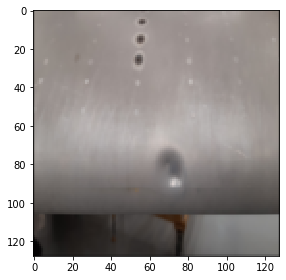

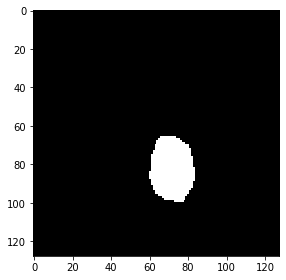

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


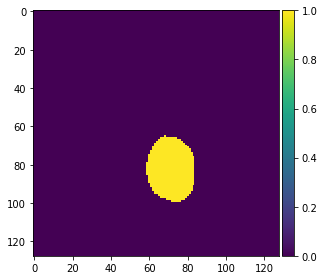

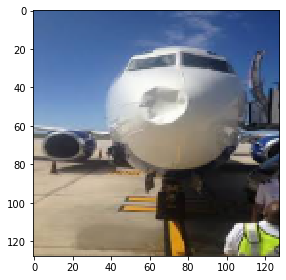

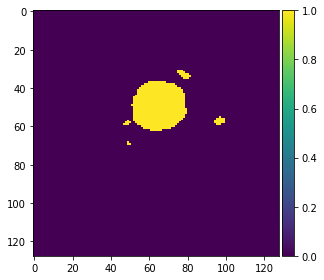

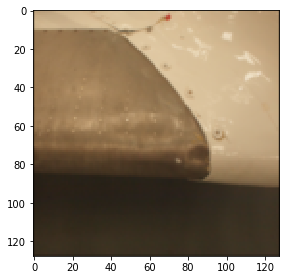

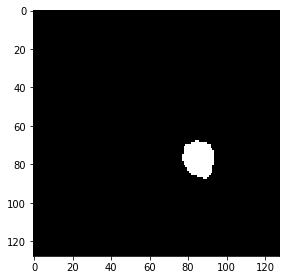

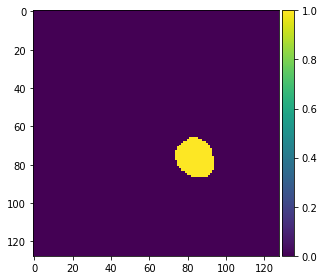

In [25]:
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5 ).astype(np.uint8)

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random testing samples
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()
#imshow(np.squeeze(Y_test[ix]))
#plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()

# Perform a sanity check on some random testing samples
ix = 4
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(Y_test[ix]))
plt.show()
#imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
#plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()


In [26]:
model.evaluate(X_test, Y_test, return_dict= True)

1/1 [==============================] - 0s 169ms/step - loss: 0.0620 - accuracy: 0.9863


{'accuracy': 0.9862874150276184, 'loss': 0.06200657784938812}

In [27]:
m = tf.keras.metrics.Recall()
m.update_state( Y_test, preds_test, sample_weight=None)
m.result().numpy()

0.84428906

In [28]:
m = tf.keras.metrics.Precision()
m.update_state( Y_test, preds_test, sample_weight=None)
m.result().numpy()

0.64106196

In [29]:
m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state( Y_test, preds_test, sample_weight=None)
m.result().numpy()

0.5550408

In [30]:
# Save our model as saved_model format
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [31]:
# Covert to Tensorflow Lite format 
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/my_model')
tflite_model = converter.convert()
open("Unet_testmodel.tflite", "wb").write(tflite_model)

124688724